# Calibration

In [1]:
import multiprocessing as mp
import platform

if platform.system() != "Windows":
    mp.set_start_method('forkserver')


from tb_incubator.constants import set_project_base_path
from tb_incubator.input import load_targets, load_param_info
from tb_incubator.calibrate import get_bcm, tabulate_calib_results, plot_posterior_comparison
from tb_incubator.plotting import plot_model_vs_actual

from estival.wrappers import pymc as epm
import pymc as pm

import arviz as az
from estival.sampling.tools import likelihood_extras_for_idata

#pd.options.plotting.backend = "plotly"  
project_paths = set_project_base_path("../tb_incubator/")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
params= load_param_info()["value"]
param_info = load_param_info()

In [3]:
bcm = get_bcm(params)

In [4]:
def calibrate(draws, tune):
    with pm.Model() as model:
        variables = epm.use_model(bcm)
        idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=draws, tune=tune,cores=8,chains=8)

    return idata

In [5]:
idata = calibrate(2000, 2000)

Population sampling (16 chains)
DEMetropolis: [contact_rate, self_recovery_rate, base_sensitivity, genexpert_sensitivity, progression_multiplier, prevalence_dispersion, notification_dispersion]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Output()

Population parallelization failed. Falling back to sequential stepping of chains.


Output()

Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 1205 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
likelihood_df = likelihood_extras_for_idata(idata, bcm)
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)
map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()
map_res = bcm.run(map_params)

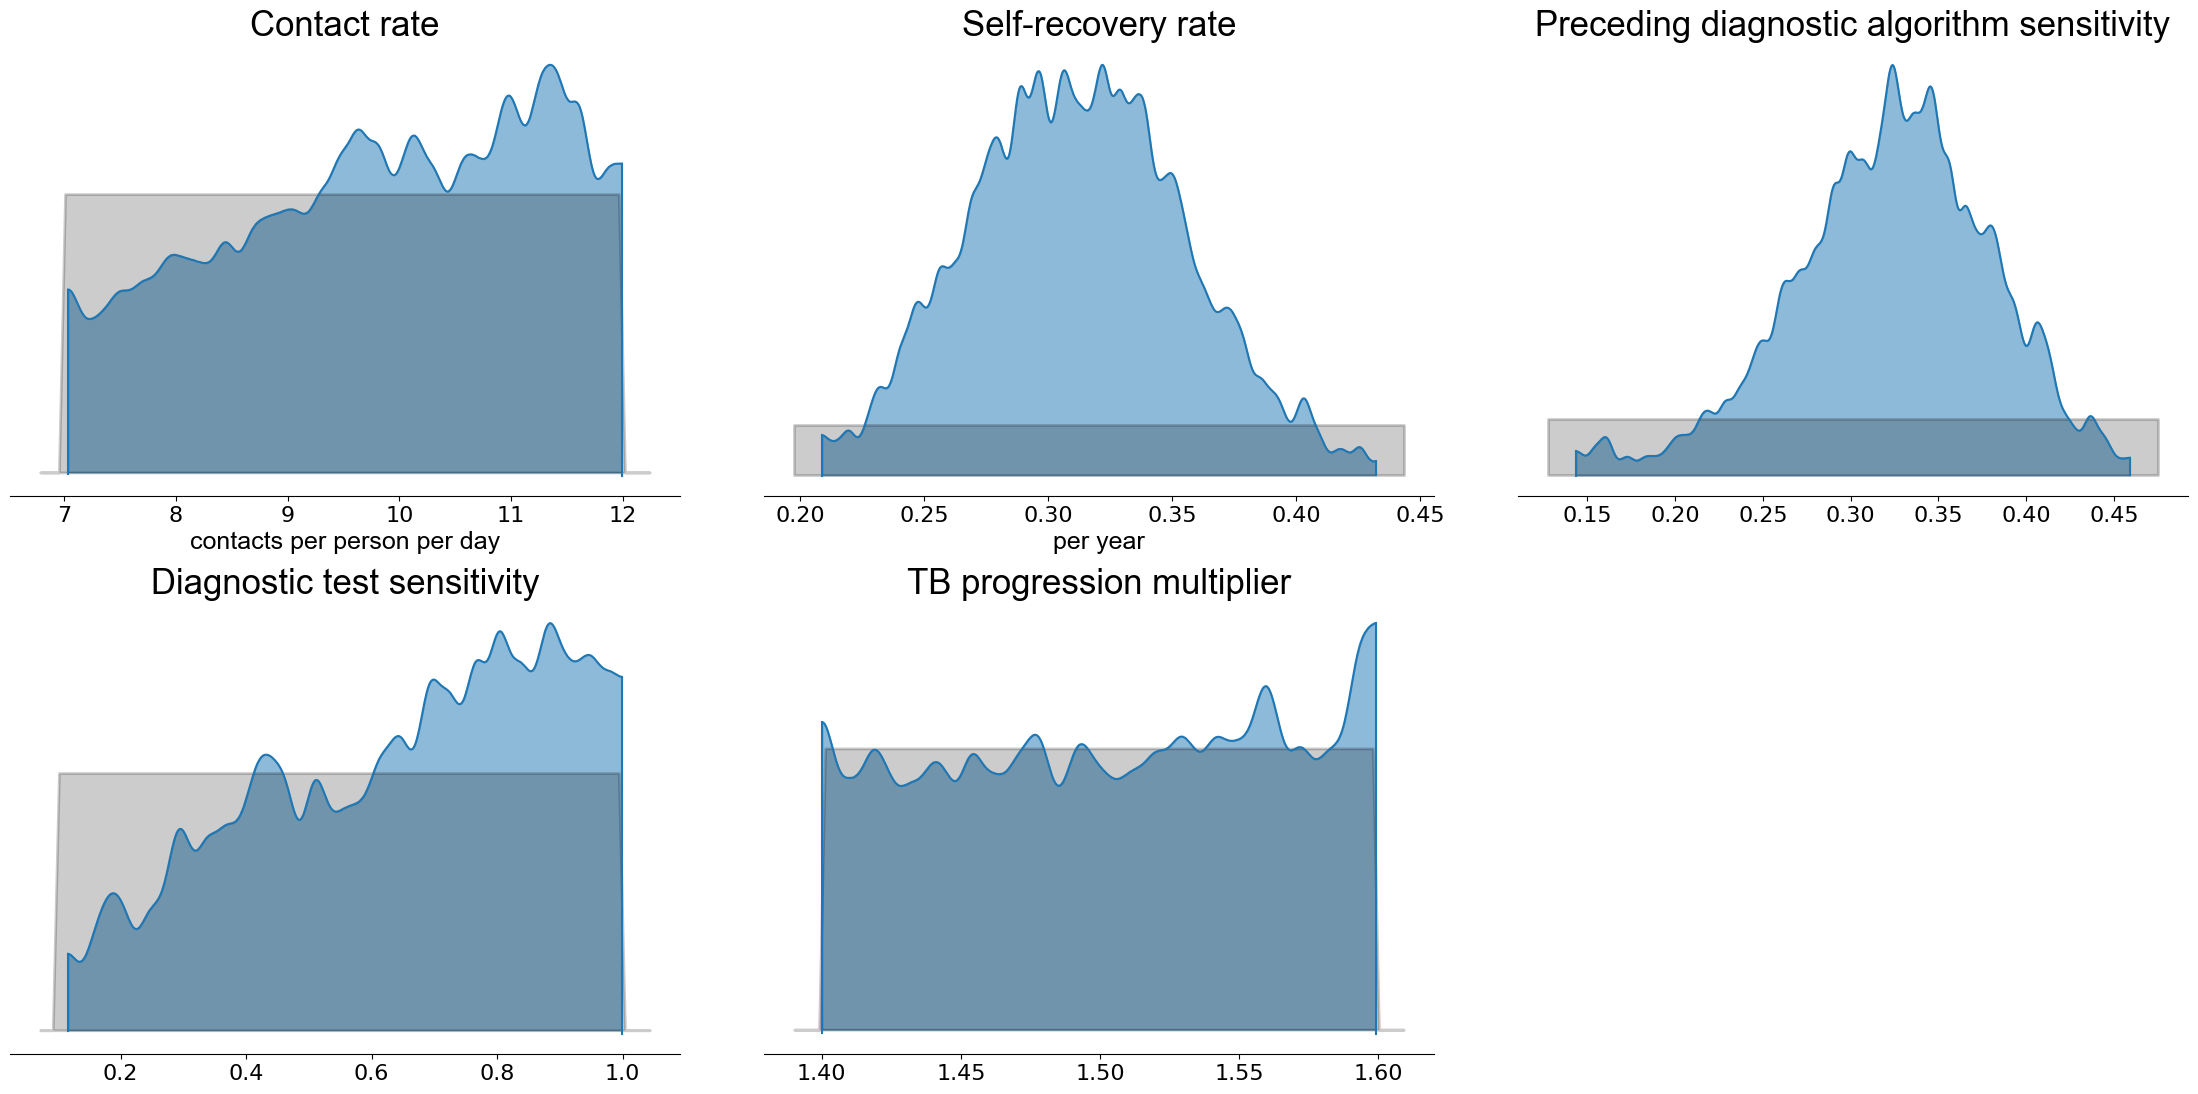

In [7]:
plot_posterior_comparison(idata, 0.995)

In [8]:
tabulate_calib_results(idata, param_info)

,Mean,Standard deviation,ESS bulk,ESS tail,\textit{\^{R}},High-density interval
Parameter,,,,,,
Preceding diagnostic algorithm sensitivity,0.323,0.058,648.0,321.0,1.02,0.219 to 0.437
Contact rate,9.81,1.37,504.0,560.0,1.03,7.49 to 12.0
Diagnostic test sensitivity,0.645,0.236,585.0,846.0,1.03,0.24 to 0.999
TB progression multiplier,1.5,0.059,417.0,499.0,1.03,1.41 to 1.6
Self-recovery rate,0.312,0.044,479.0,513.0,1.03,0.229 to 0.392


In [9]:
variable = "notification"
fig = plot_model_vs_actual(map_res.derived_outputs, 
                     bcm.targets[variable].data,
                     variable,
                     variable,
                     "",
                     "Actual data")
#fig.update_xaxes(range=[1998, 2023])
fig



In [10]:
variable = "prevalence"
fig = plot_model_vs_actual(map_res.derived_outputs, 
                     bcm.targets[variable].data,
                     variable,
                     variable,
                     "",
                     "Actual data")
#fig.update_xaxes(range=[1998, 2023])
fig